# COURSE: PCA and multivariate neural signal processing
## SECTION: Independent components analysis
### VIDEO: Python: ICA, PCA, GED on simulated data
#### Instructor: sincxpress.com

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import copy
import scipy
import scipy.io as sio
from pytopo import topoplotIndie
# from filterFGxfun import filterFGx
import jade

### Part 1: our favorite "X" data

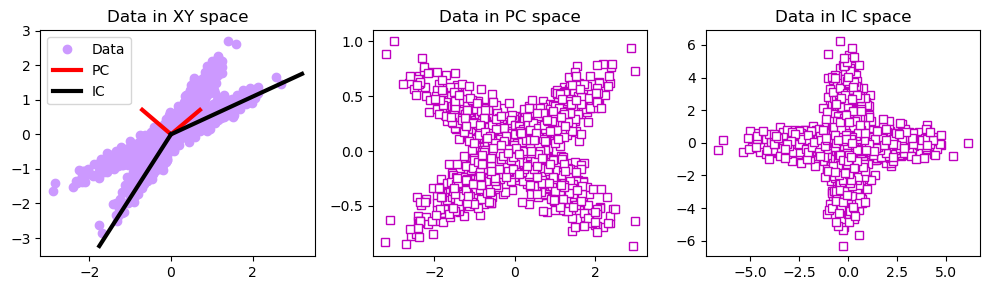

In [16]:
# simple example of the "X" data

## generate data
x = np.random.randn(1000,2)
x[:,1] *= .12

# rotation matrix
th = -np.pi/6
R1 = [ [np.cos(th),-np.sin(th)], [np.sin(th),np.cos(th)] ]
th = -np.pi/3
R2 = [ [np.cos(th),-np.sin(th)], [np.sin(th),np.cos(th)] ]

# rotate data
y = np.concatenate((x@R1,x@R2))

# now PCA
y[:,0] -= np.mean(y[:,0])
y[:,1] -= np.mean(y[:,1])
evalsY,evecsY = np.linalg.eig( (y.T@y) / len(y) )
# compute PC scores
pc1 = y@evecsY[:,0]
pc2 = y@evecsY[:,1]

# now ICA
ivecs = jade.main(y.T,4)[0]
ic_scores = np.array(ivecs)@y.T



### plotting
_,axs = plt.subplots(1,3,figsize=(10,3))
axs[0].plot(y[:,0],y[:,1],'o',label='Data',color=[.8,.6,1])
axs[0].plot([0,evecsY[0,0]],[0,evecsY[1,0]],'r',linewidth=3,label='PC')
axs[0].plot([0,evecsY[0,1]],[0,evecsY[1,1]],'r',linewidth=3)
axs[0].plot([0,ivecs[0,0]],[0,ivecs[1,0]],'k',linewidth=3,label='IC')
axs[0].plot([0,ivecs[0,1]],[0,ivecs[1,1]],'k',linewidth=3)
axs[0].legend()
axs[0].set_title('Data in XY space')

# data in PC space
axs[1].plot(pc1,pc2,'ms',markerfacecolor='w')
axs[1].set_title('Data in PC space')

# data in IC space
axs[2].plot(ic_scores[0,:],ic_scores[1,:],'ms',markerfacecolor='w')
axs[2].set_title('Data in IC space')

plt.tight_layout()
plt.show()


## Part 2: Simulated EEG data

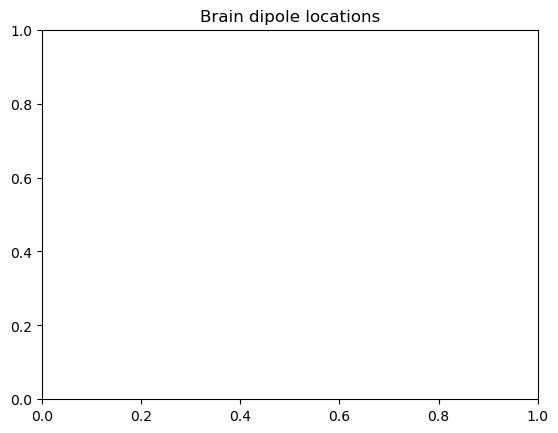

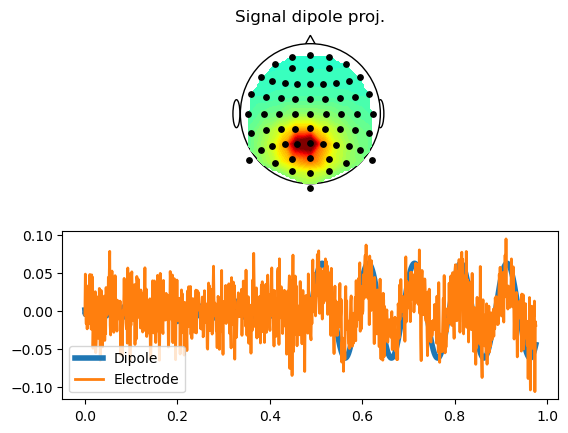

In [18]:
## preliminary 

# mat file containing EEG, leadfield and channel locations
matfile = sio.loadmat('MATLAB_data_files//emptyEEG')
lf = matfile['lf'][0,0]
EEG = matfile['EEG'][0,0]

diploc = 108

# normal dipoles (normal to the surface of the cortex)
lf_GainN = np.zeros((64,2004))
for i in range(3):
    lf_GainN += lf['Gain'][:,i,:]*lf['GridOrient'][:,i]


### simulate the data
dipole_data = 1*np.random.randn(lf['Gain'].shape[2],1000)
# add signal to second half of dataset
dipole_data[diploc,500:] = 15*np.sin(2*np.pi*10*np.arange(500)/EEG['srate'])
# project dipole data to scalp electrodes
EEG['data'] = lf_GainN@dipole_data
# meaningless time series
EEG['times'] = np.squeeze(np.arange(EEG['data'].shape[1])/EEG['srate'])







# plot brain dipoles
ax = Axes3D(plt.figure())
ax.scatter(lf['GridLoc'][:,0], lf['GridLoc'][:,1], lf['GridLoc'][:,2], 'bo')
ax.scatter(lf['GridLoc'][diploc,0], lf['GridLoc'][diploc,1], lf['GridLoc'][diploc,2], marker='o',s=100)
plt.title('Brain dipole locations')
plt.show()

_,axs = plt.subplots(2,1)
topoplotIndie(lf_GainN[:,diploc],EEG['chanlocs'],'Signal dipole proj.',axs[0])

axs[1].plot(EEG['times'],dipole_data[diploc,:]/np.linalg.norm(dipole_data[diploc,:]),linewidth=4,label='Dipole')
axs[1].plot(EEG['times'],EEG['data'][30,:]/np.linalg.norm(EEG['data'][30,:]),linewidth=2,label='Electrode')
axs[1].legend()
plt.show()

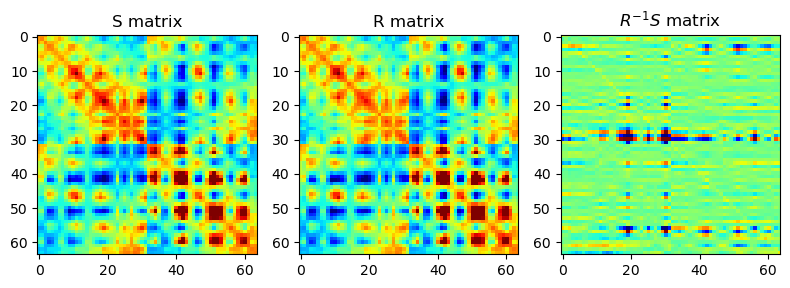

In [19]:
## Create covariance matrices

# compute covariance matrix R is first half of data
tmpd = EEG['data'][:,:500]
covR = np.cov(tmpd)

# compute covariance matrix S is second half of data
tmpd = EEG['data'][:,500:]
covS = np.cov(tmpd)


### plot the two covariance matrices
_,axs = plt.subplots(1,3,figsize=(8,4))

# S matrix
axs[0].imshow(covS,vmin=-1e6,vmax=1e6,cmap='jet')
axs[0].set_title('S matrix')

# R matrix
axs[1].imshow(covR,vmin=-1e6,vmax=1e6,cmap='jet')
axs[1].set_title('R matrix')

# R^{-1}S
axs[2].imshow(np.linalg.inv(covR)@covS,vmin=-10,vmax=10,cmap='jet')
axs[2].set_title('$R^{-1}S$ matrix')

plt.tight_layout()
plt.show()

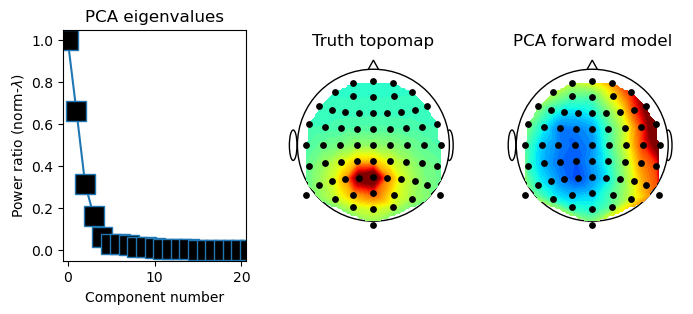

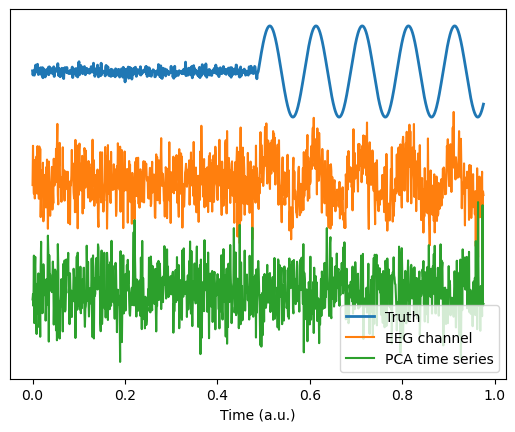

In [20]:
## Dimension compression via PCA

# PCA
evals,evecs = scipy.linalg.eigh(covS+covR)

# sort eigenvalues/vectors
sidx  = np.argsort(evals)[::-1]
evals = evals[sidx]
evecs = evecs[:,sidx]



# plot the eigenspectrum
_,axs = plt.subplots(1,3,figsize=(8,3))
axs[0].plot(evals/np.max(evals),'s-',markersize=15,markerfacecolor='k')
axs[0].set_xlim([-.5,20.5])
axs[0].set_title('PCA eigenvalues')
axs[0].set_xlabel('Component number')
axs[0].set_ylabel('Power ratio (norm-$\lambda$)')

# filter forward model
filt_topo = evecs[:,0]

# Eigenvector sign
se = np.argmax(np.abs( filt_topo ))
filt_topo = filt_topo * np.sign(filt_topo[se])

# plot the maps
topoplotIndie(lf_GainN[:,diploc],EEG['chanlocs'],'Truth topomap',axs[1])
topoplotIndie(filt_topo,EEG['chanlocs'],'PCA forward model',axs[2])

plt.show()



# component time series is eigenvector as spatial filter for data
comp_ts = evecs[:,0].T@EEG['data']


# normalize time series (for visualization)
dipl_ts = dipole_data[diploc,:] / np.linalg.norm(dipole_data[diploc,:])
comp_ts = comp_ts / np.linalg.norm(comp_ts)
chan_ts = EEG['data'][30,:] / np.linalg.norm(EEG['data'][30,:])


# plot the time series
plt.plot(EEG['times'],.3+dipl_ts,linewidth=2)
plt.plot(EEG['times'],.15+chan_ts)
plt.plot(EEG['times'],comp_ts)
plt.legend(['Truth','EEG channel','PCA time series'])
plt.yticks([])
plt.xlabel('Time (a.u.)')
plt.show()

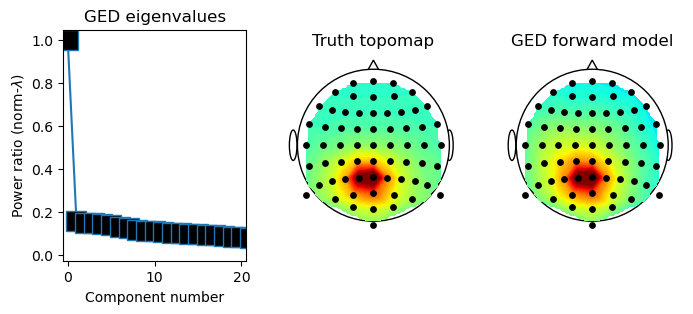

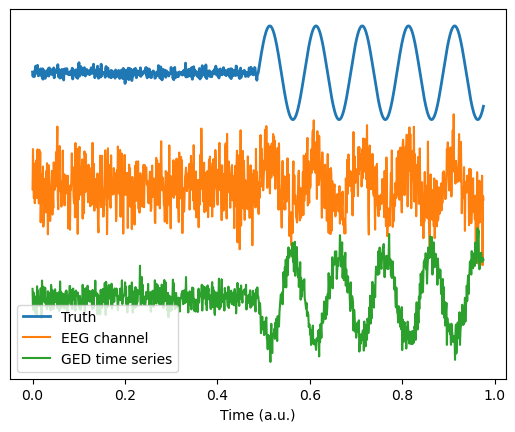

In [21]:
## Source separation via GED

# GED
evals,evecs = scipy.linalg.eigh(covS,covR)

# sort eigenvalues/vectors
sidx  = np.argsort(evals)[::-1]
evals = evals[sidx]
evecs = evecs[:,sidx]



# plot the eigenspectrum
_,axs = plt.subplots(1,3,figsize=(8,3))
axs[0].plot(evals/np.max(evals),'s-',markersize=15,markerfacecolor='k')
axs[0].set_xlim([-.5,20.5])
axs[0].set_title('GED eigenvalues')
axs[0].set_xlabel('Component number')
axs[0].set_ylabel('Power ratio (norm-$\lambda$)')

# filter forward model
filt_topo = evecs[:,0].T@covS

# Eigenvector sign
se = np.argmax(np.abs( filt_topo ))
filt_topo = filt_topo * np.sign(filt_topo[se])

# plot the maps
topoplotIndie(lf_GainN[:,diploc],EEG['chanlocs'],'Truth topomap',axs[1])
topoplotIndie(filt_topo,EEG['chanlocs'],'GED forward model',axs[2])

plt.show()



# component time series is eigenvector as spatial filter for data
comp_ts = evecs[:,0].T@EEG['data']


# normalize time series (for visualization)
comp_ts = comp_ts / np.linalg.norm(comp_ts)


# plot the time series
plt.plot(EEG['times'],.3+dipl_ts,linewidth=2)
plt.plot(EEG['times'],.15+chan_ts)
plt.plot(EEG['times'],comp_ts)
plt.legend(['Truth','EEG channel','GED time series'])
plt.yticks([])
plt.xlabel('Time (a.u.)')
plt.show()

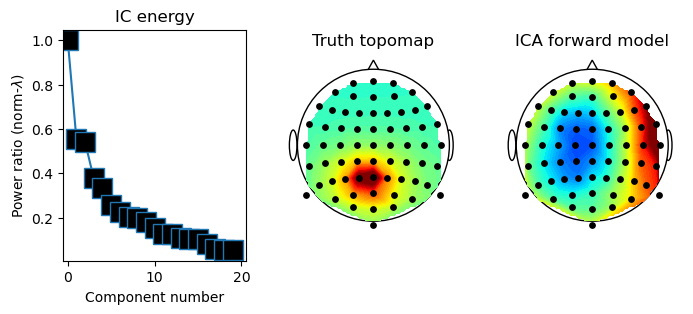

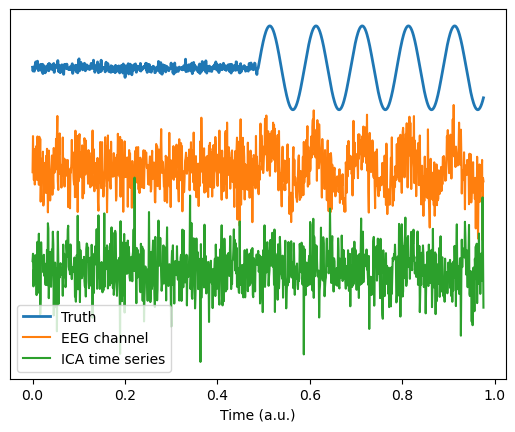

In [22]:
## Source separation via ICA

# NOTE: ICA takes several minutes to compute. Have patience...

# ICA and scores
icvecs = jade.main(EEG['data'],20)[0]
icvecs = np.array( icvecs )
ICs    = icvecs[0,:]@EEG['data']
icmaps = np.linalg.pinv(icvecs.T)
ICenergy = np.sum(icmaps**2,axis=1)



# plot component energy
_,axs = plt.subplots(1,3,figsize=(8,3))
axs[0].plot(ICenergy/np.max(ICenergy),'s-',markersize=15,markerfacecolor='k')
axs[0].set_xlim([-.5,20.5])
axs[0].set_title('IC energy')
axs[0].set_xlabel('Component number')
axs[0].set_ylabel('Power ratio (norm-$\lambda$)')

# plot the maps
topoplotIndie(lf_GainN[:,diploc],EEG['chanlocs'],'Truth topomap',axs[1])
topoplotIndie(icmaps[0,:],EEG['chanlocs'],'ICA forward model',axs[2])

plt.show()



# component time series is eigenvector as spatial filter for data
comp_ts = evecs[:,0].T@EEG['data']


# normalize time series (for visualization)
comp_ts = ICs / np.linalg.norm(ICs)


# plot the time series
plt.plot(EEG['times'],.3+dipl_ts,linewidth=2)
plt.plot(EEG['times'],.15+chan_ts)
plt.plot(EEG['times'],comp_ts.T)
plt.legend(['Truth','EEG channel','ICA time series'])
plt.yticks([])
plt.xlabel('Time (a.u.)')
plt.show()

In [ ]:
### Note about the visualization of the ICs:
# The columns correspond to vectors that are orthogonal in the 
# IC space -- though they are not orthogonal in the data space.
# That's why they point along the data directions.
# Therefore, plotting the columns of the IC matrix is actually not
# the IC _projection_ vectors, but the IC-space _basis vectors_.
# Plotting the rows of the IC matrix in the data space is the projection
# vectors, which are orthogonal to the two "streams" of data
# (each leg of the "X" pattern).